# ASHRAE Energy Predictions:

### Import of necessary packages:

In [5]:
import numpy as np 
import pandas as pd 
import seaborn as sns  
import matplotlib.pyplot as plt   

### Loading data:

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
weather_train = pd.read_csv('weather_train.csv')
weather_test= pd.read_csv('weather_test.csv')
meta = pd.read_csv('building_metadata.csv')
submiss = pd.read_csv('sample_submission.csv')

In [7]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [8]:
print('train shape is {}'.format(train.shape))
print('test shape is {}'.format(test.shape))
print('weather_train shape is {}'.format(weather_train.shape))
print('weather_test shape is {}'.format(weather_test.shape))
print('metadata shape is {}'.format(meta.shape))

train shape is (20216100, 4)
test shape is (41697600, 4)
weather_train shape is (139773, 9)
weather_test shape is (277243, 9)
metadata shape is (1449, 6)


### Merging data:

In [4]:
train = train.merge(meta, on = 'building_id', how = 'left')
test = test.merge(meta, on = 'build
                  
                  ing_id', how = 'left')

train = train.merge(weather_train, on = ['site_id', 'timestamp'], how = 'left')
test = test.merge(weather_test, on = ['site_id', 'timestamp'], how = 'left')

del weather_train,weather_test,meta

In [24]:
train.shape

(20216100, 16)

In [25]:
test.shape

(41697600, 16)

### Categorical/continuous variable:

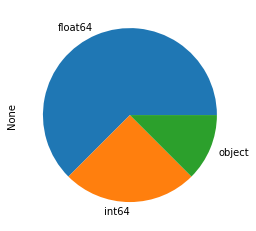

In [27]:
train.dtypes.value_counts().plot.pie()

### Memory reduction:

In [28]:
def memory_reduction(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [29]:
train = memory_reduction(train)
test = memory_reduction(test)

Memory usage of dataframe is 2622.02 MB
Memory usage after optimization is: 790.84 MB
Decreased by 69.8%
Memory usage of dataframe is 5408.17 MB
Memory usage after optimization is: 1631.16 MB
Decreased by 69.8%


### Missing values:

In [5]:
def get_missing_info(df):
    num_entries = df.shape[0]*df.shape[1]
    null_entries = df.isnull().sum().sum()
    percent_empty = null_entries/num_entries*100
    
    num_missing = df.isna().sum()
    percent_missing = num_missing/len(df)*100
    col_modes = df.mode().loc[0]         # ce qu'il apparait le plus souvent 
    percent_mode = [df[x].isin([df[x].mode()[0]]).sum()/len(df)*100 for x in df]
    missing_value_df = pd.DataFrame({'num_missing': num_missing,
                                     'percent_missing': percent_missing})
    print('total empty percent:', percent_empty, '%')
    return(missing_value_df)

In [6]:
get_missing_info(train)

total empty percent: 13.736697174529212 %


,num_missing,percent_missing
building_id,0,0.000000
meter,0,0.000000
timestamp,0,0.000000
meter_reading,0,0.000000
site_id,0,0.000000
primary_use,0,0.000000
square_feet,0,0.000000
year_built,12127645,59.990033
floor_count,16709167,82.652772
air_temperature,96658,0.478124


### Converting datetime variable 'timestamp':

In [7]:
train["timestamp"] = pd.to_datetime(train["timestamp"])
train["hour"] = np.uint8(train["timestamp"].dt.hour)
train["day"] = np.uint8(train["timestamp"].dt.day)
train["weekday_name"] = train["timestamp"].dt.weekday_name 
train["weekday"] = np.uint8(train["timestamp"].dt.weekday)
train["month"] = np.uint8(train["timestamp"].dt.month)


test["timestamp"] = pd.to_datetime(test["timestamp"])
test["hour"] = np.uint8(test["timestamp"].dt.hour)
test["day"] = np.uint8(test["timestamp"].dt.day)
test["weekday"] = np.uint8(test["timestamp"].dt.weekday)
test["month"] = np.uint8(test["timestamp"].dt.month)

### Encoding of the variable 'meter':

In [8]:
train['meter'].replace({0:"electricity",1:"chilledwater",2:"steam",3:"hotwater"},inplace=True)
test['meter'].replace({0:"electricity",1:"chilledwater",2:"steam",3:"hotwater"},inplace=True)

### Defining function to plot distributions:

In [9]:
def distplot(var,color):
    plt.rcParams['figure.figsize'] = (10, 8)
    ax = sns.distplot(var, color = color)
    plt.xlabel('%s' %var.name, fontsize =14)
    plt.ylabel('Count ', fontsize =14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.title(' Distribution of '+'%s' %var.name)
    plt.show()

C:\Users\HP\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


AttributeError: 'list' object has no attribute 'set_title'

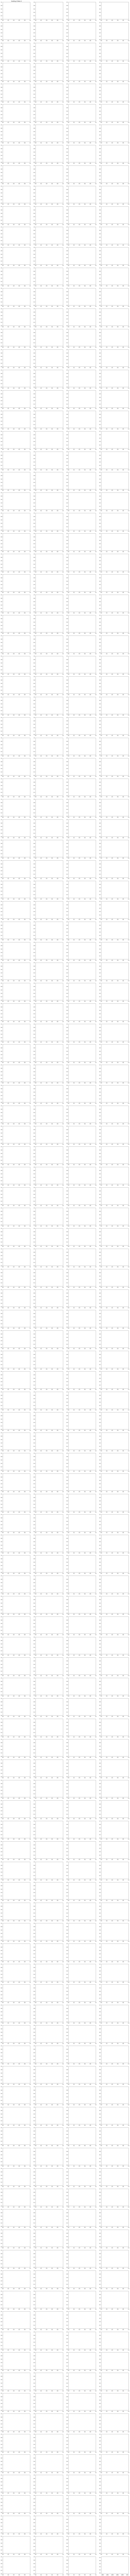

In [10]:
fig,ax = plt.subplots(126,4,figsize=(24,504))
i=0
j=0

for b_id in range(0,1449):
    if b_id <500:
        ax[i][j].set_title(f'Building {b_id} Meter 0')
        ax[i][j]=plt.plot(train[(train.building_id == b_id) & (train.meter ==0 )]['timestamp'], train[(train.building_id == b_id) & (train.meter == 0)]['meter_reading'])
        j+=1
        if j==1:
            j+=1
            j=0
    else:
        break
plt.show()

#### Distribution of target variable: meter_reading

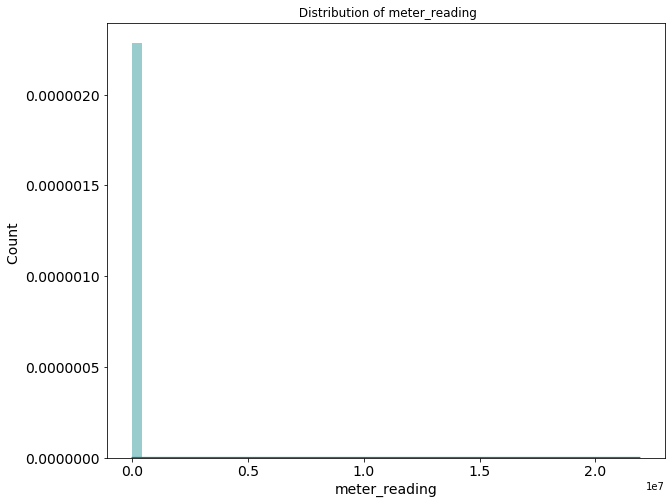

In [35]:
distplot(train['meter_reading'], 'teal')

In [36]:
train['meter_reading'].describe()

count    2.021610e+07
mean     1.988706e+03
std      1.532159e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

In [41]:
(train['meter_reading']==0).value_counts()

False    18342124
True      1873976
Name: meter_reading, dtype: int64

#### Convert meter_reading to log1p(meter_reading):

In [42]:
train['meter_reading'] = np.log1p(train['meter_reading'])

#### Distribution of log1p(meter_reading):

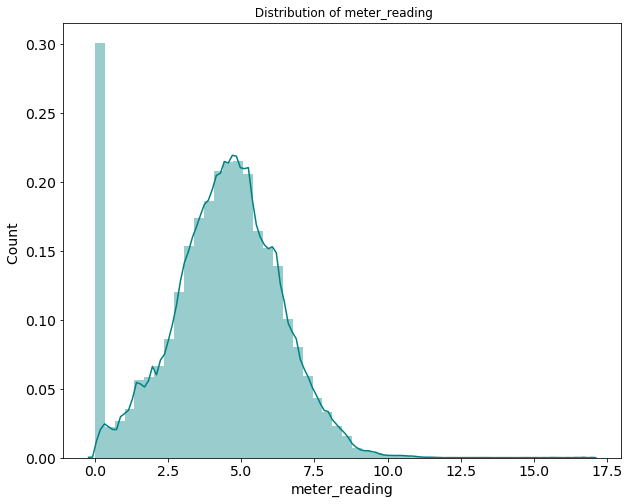

In [44]:
distplot(train['meter_reading'],'teal')   # distribution après le passage en log 

#### Distribution of meter_type:

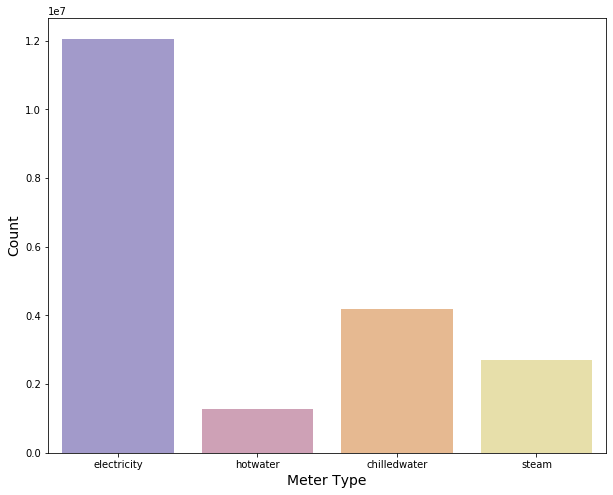

In [45]:
plt.rcParams['figure.figsize'] = (10, 8)
ax = sns.countplot(data = train, x ='meter', palette = 'CMRmap', alpha = 0.5)
ax.set_ylabel('Count', fontsize = 14)
ax.set_xlabel('Meter Type', fontsize = 14)
plt.show()

#### boxplot of log1p(meter_reading) according to weekdays:

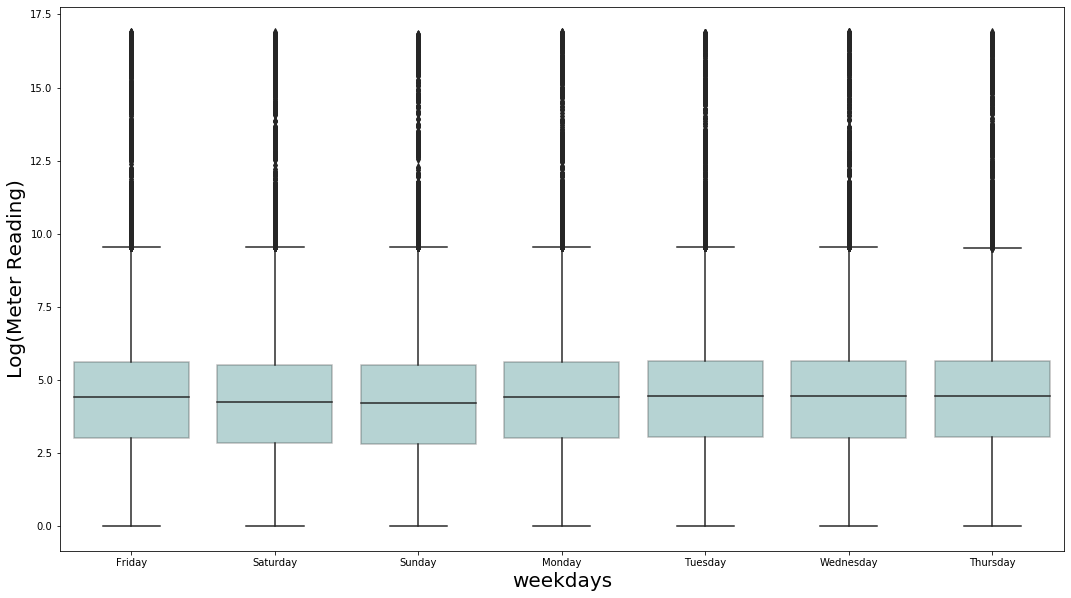

In [28]:
plt.rcParams['figure.figsize'] = (18, 10)
ax = sns.boxplot(data = train, x ='weekday_name', y = 'meter_reading', color = 'teal', boxprops=dict(alpha=.3))
ax.set_ylabel('Log(Meter Reading)', fontsize = 20)
ax.set_xlabel('weekdays', fontsize = 20)
plt.show()

=> Sundays have the lowest reading

#### meter_reading every hour:

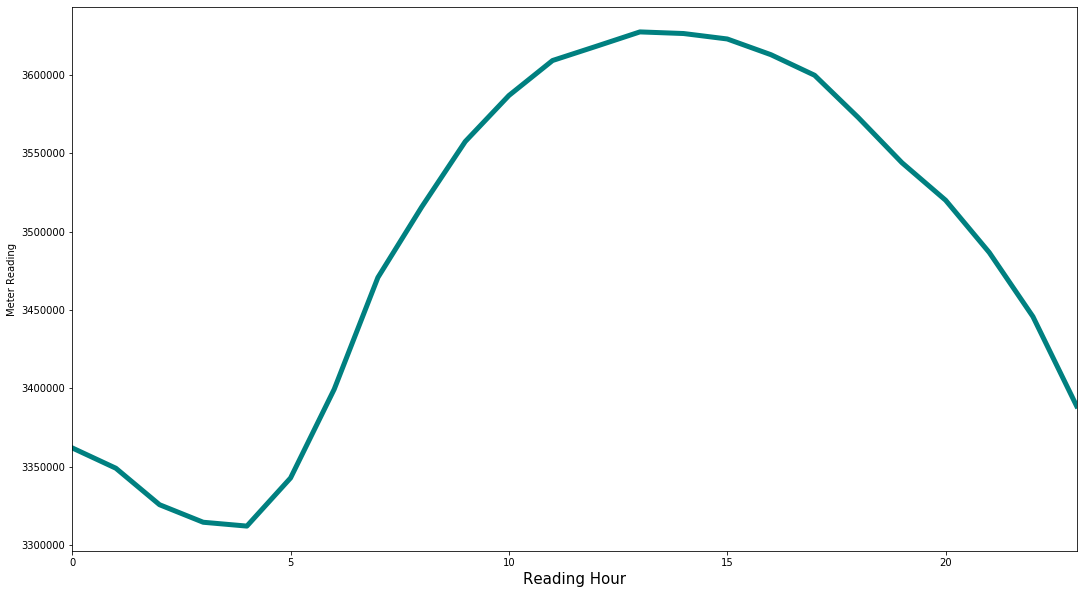

In [29]:
plt.rcParams['figure.figsize'] = (18,10)
temp_df = train.groupby('hour').meter_reading.sum()
temp_df.plot(linewidth = 5, color = 'teal')
plt.xlabel('Reading Hour', fontsize = 15)
plt.ylabel('Meter Reading')
plt.show()

high consumption between 7 am and 8 pm

#### Categorial variables:

In [46]:
for col in train.select_dtypes('category'):
    print(col)

timestamp
primary_use


In [47]:
for col in train.select_dtypes('object'):
    print(col)

meter
weekday_name


**primary_use:**

In [49]:
train['primary_use'].value_counts()

Education                        8165504
Office                           4394864
Entertainment/public assembly    2264917
Lodging/residential              2146413
Public services                  1662826
Healthcare                        398527
Other                             242222
Parking                           213796
Manufacturing/industrial          125713
Food sales and service            114090
Retail                            112657
Warehouse/storage                 111861
Services                           96519
Technology/science                 77627
Utility                            56203
Religious worship                  32361
Name: primary_use, dtype: int64

#### log1p(meter_reading) according to primary_use:

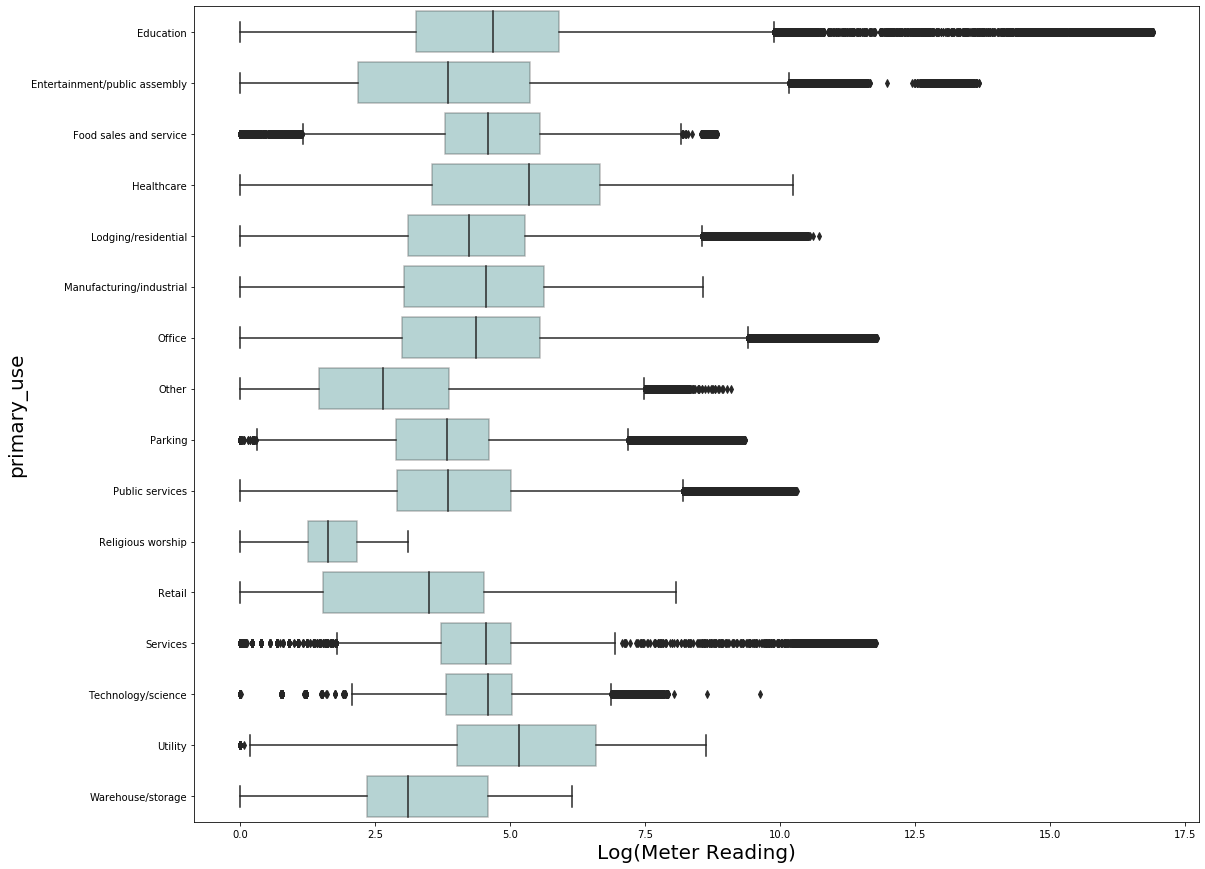

In [50]:
plt.rcParams['figure.figsize'] = (18, 15)
ax = sns.boxplot(data = train, x = 'meter_reading', y = 'primary_use',color = 'teal', boxprops=dict(alpha=.3))
ax.set_xlabel('Log(Meter Reading)', fontsize = 20)
ax.set_ylabel('primary_use', fontsize = 20)
plt.show()

- Utility and healthcare uses have the highest meter reading
- Religious use have the lowest meter reading

#### log1p(meter_reading) each month:

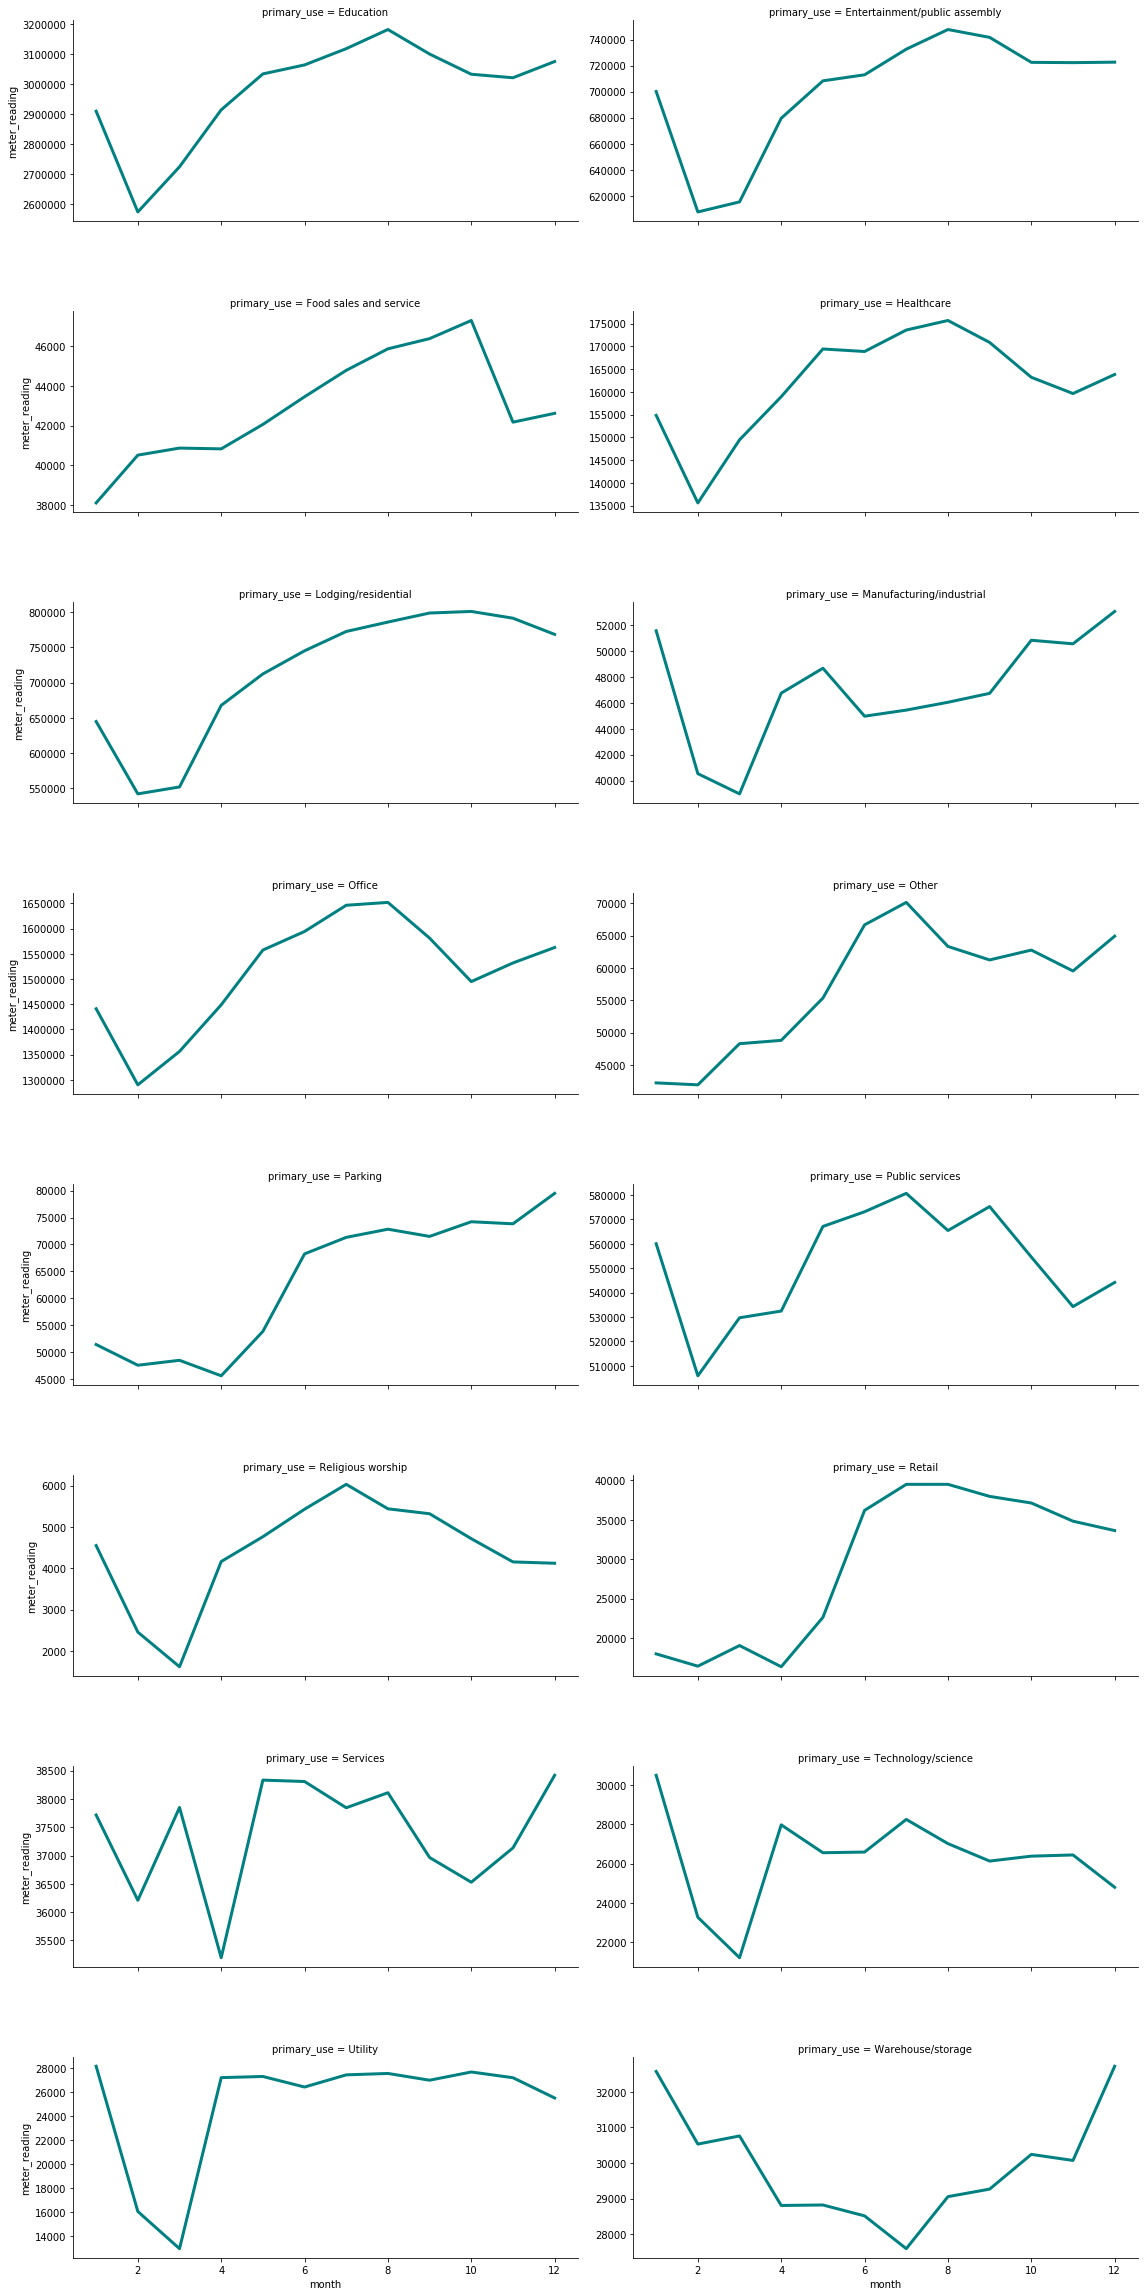

In [34]:
temp_df = train.groupby(['month', 'primary_use']).meter_reading.sum().reset_index()
ax = sns.FacetGrid(temp_df, col="primary_use", col_wrap=2, height=4, aspect=2,  sharey=False)
ax.map(plt.plot, 'month', 'meter_reading', color="teal", linewidth = 3)
plt.subplots_adjust(hspace=0.45)
plt.show()

Le peack est souvent atteint en fin d'année! à cause du froid.

#### log1p(meter_reading) for each use:

C:\Users\HP\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


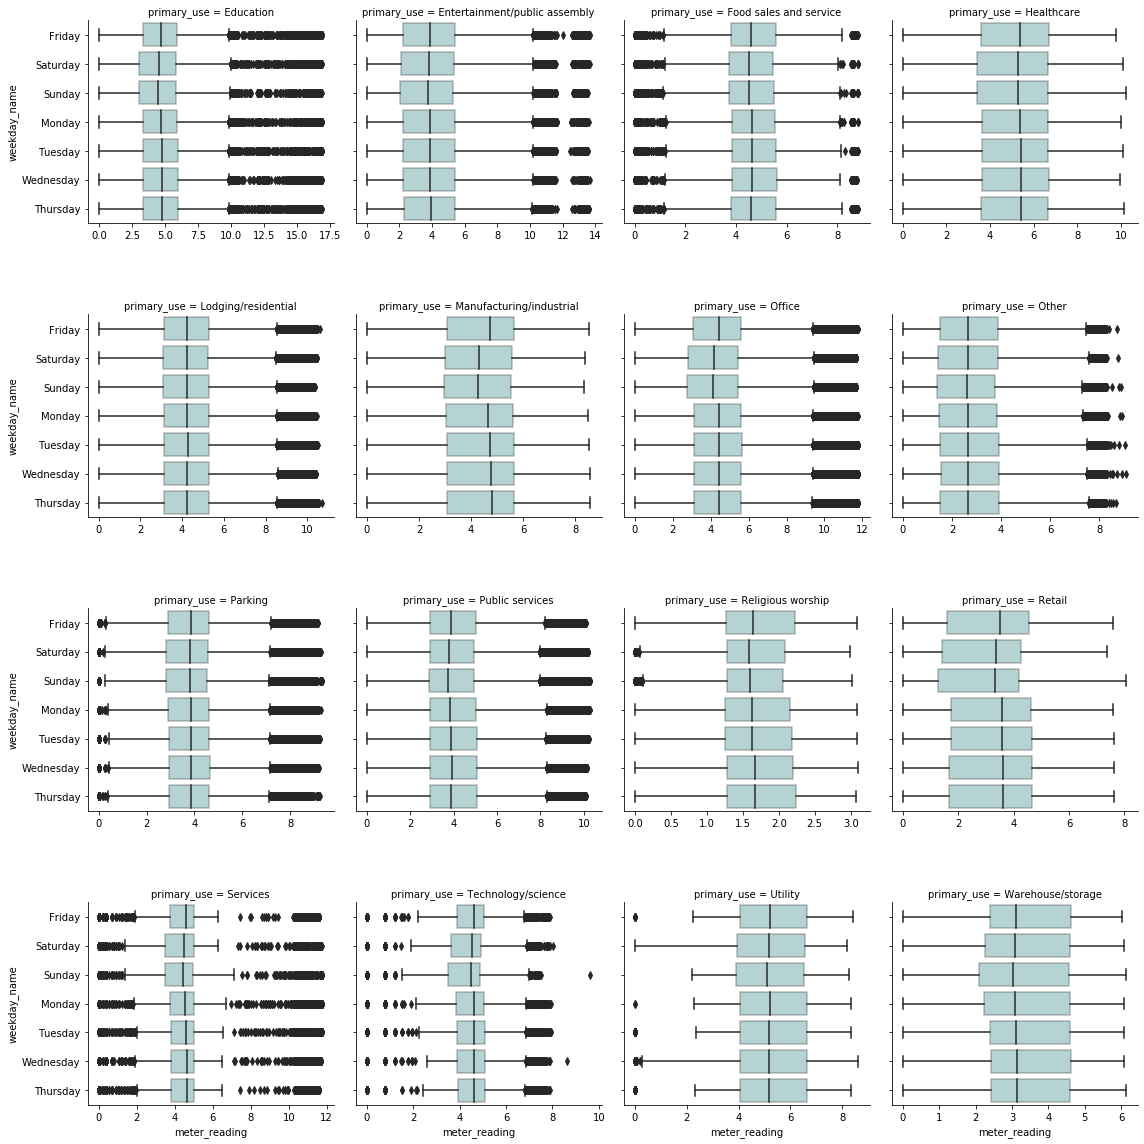

In [35]:
ax = sns.FacetGrid(train, col="primary_use", col_wrap=4, height=4, aspect=1,  sharex=False)
ax.map(sns.boxplot, 'meter_reading', 'weekday_name', color="teal",   boxprops=dict(alpha=.3))
plt.subplots_adjust(hspace=0.45)
plt.show()

#### Confusion matrix:

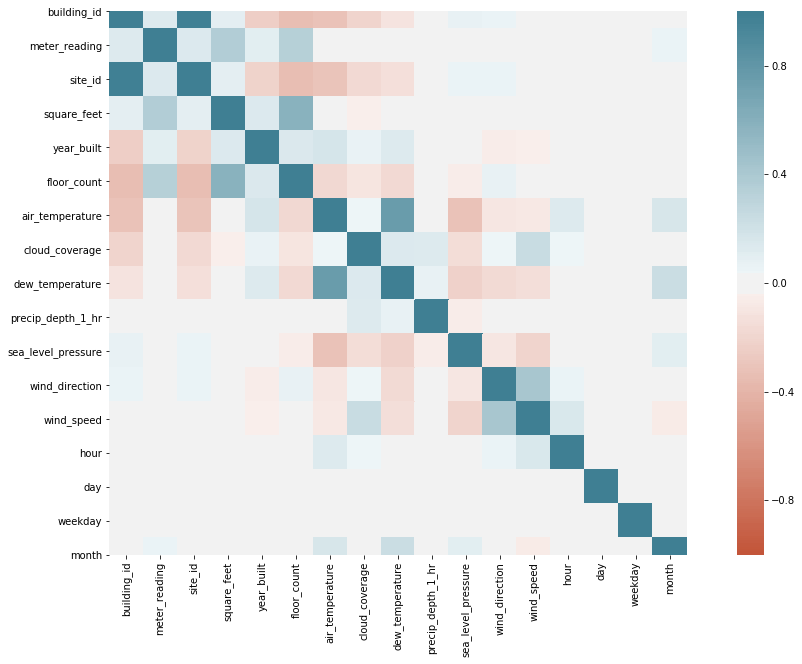

In [36]:
plt.rcParams['figure.figsize'] = (18,10)
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0,cmap = sns.diverging_palette(20, 220, n=200),square=True)
plt.show()

variables that have a great correlation with the target variable are:

#### distribution of square_feet:

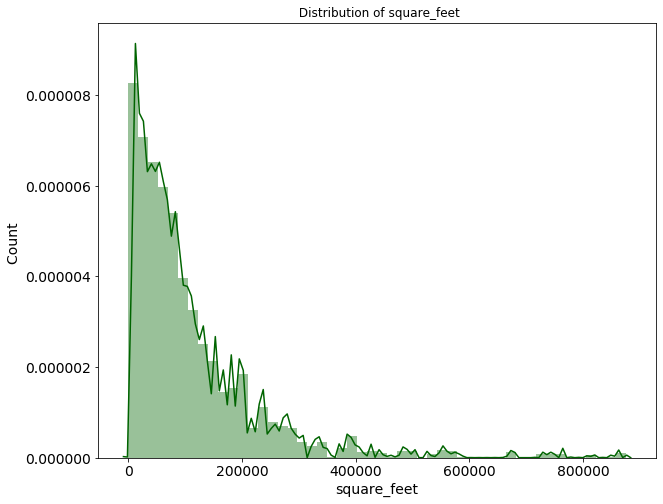

In [37]:
distplot(train['square_feet'], 'darkgreen')

#### distribution of log1p(square_feet) 

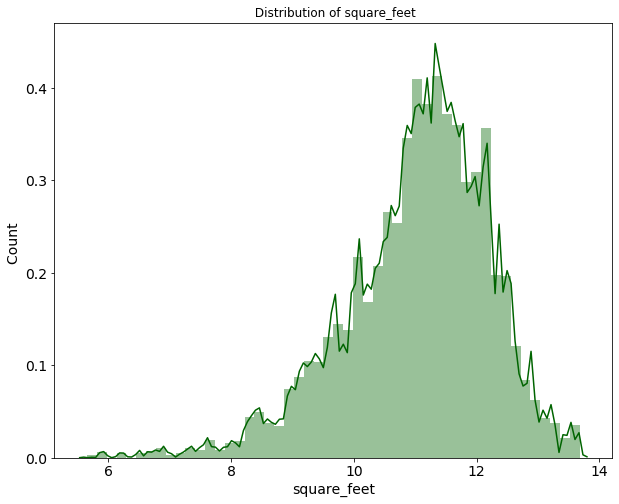

In [38]:
train['square_feet'] = np.log1p(train['square_feet'])
test['square_feet'] = np.log1p(test['square_feet'])

distplot(train['square_feet'], 'darkgreen')

#### ditribution of floor_count:

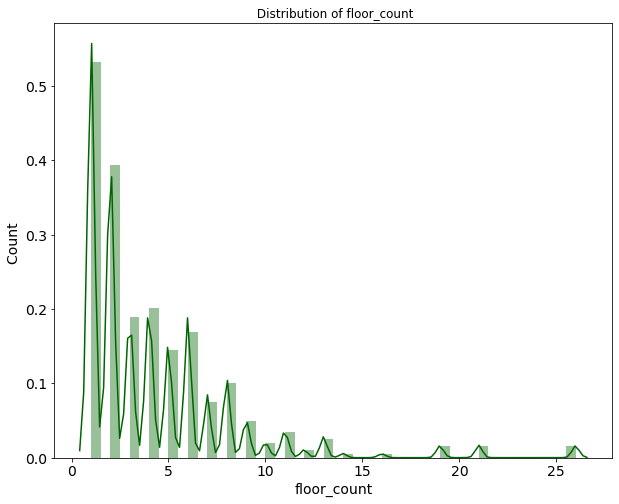

In [39]:
distplot(train['floor_count'].dropna(), 'darkgreen')

No many buildings having >= 10 floors.

#### density of air_temperature: 

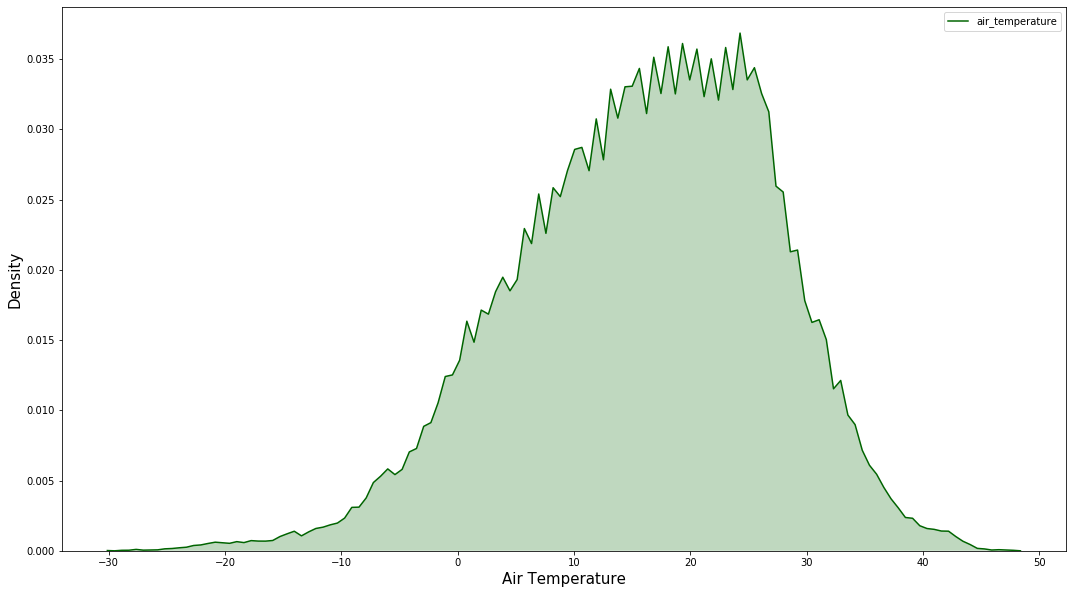

In [40]:
plt.rcParams['figure.figsize'] = (18,10)
sns.kdeplot(train['air_temperature'].dropna(), shade = True, color = 'darkgreen')
plt.xlabel('Air Temperature', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.show()

#### density of dew_temperature:

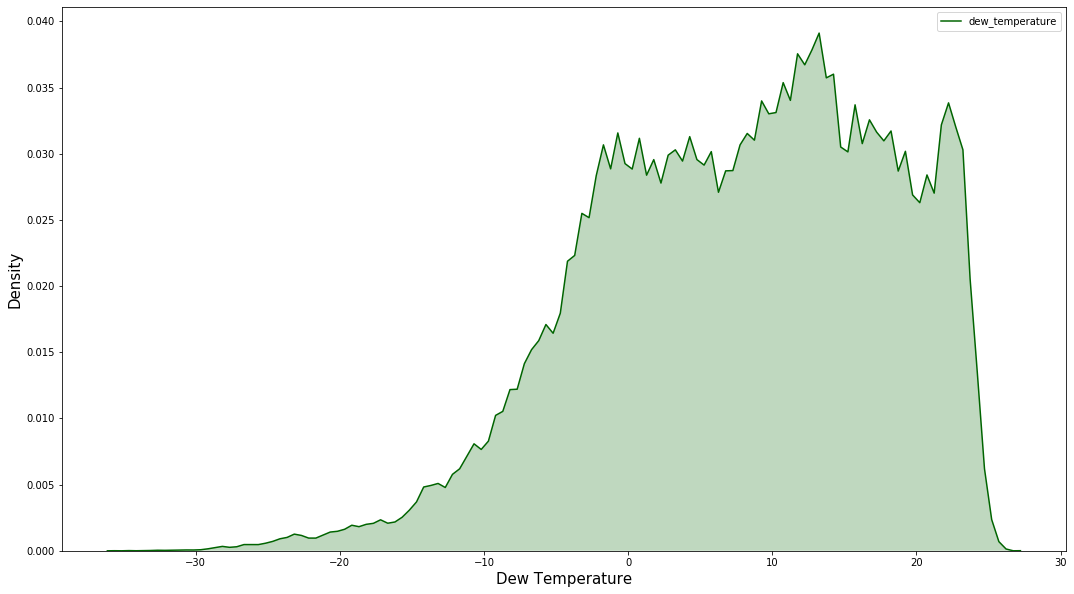

In [41]:
plt.rcParams['figure.figsize'] = (18,10)
sns.kdeplot(train['dew_temperature'].dropna(), shade = True, color = 'darkgreen')
plt.xlabel('Dew Temperature', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.show()

#### density of wind_speed:

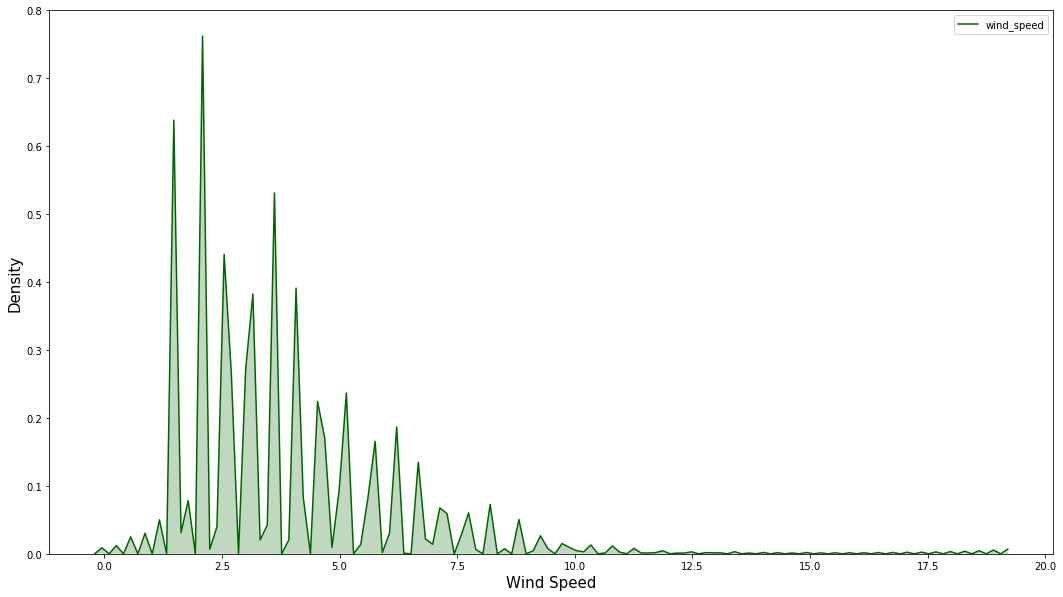

In [42]:
plt.rcParams['figure.figsize'] = (18,10)
sns.kdeplot(train['wind_speed'].dropna(), shade = True, color = 'darkgreen')
plt.xlabel('Wind Speed', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.show()

#### Imputing missing variables:

In [43]:
to_impute_by_median = train.loc[:, ['floor_count','air_temperature', 'cloud_coverage', 'dew_temperature',
                      'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction','wind_speed']]
for i in to_impute_by_median.columns:
    train[i].fillna(train[i].median(), inplace = True)

to_impute_by_median = test.loc[:, ['floor_count','air_temperature', 'cloud_coverage', 'dew_temperature',
                      'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction','wind_speed']]
for i in to_impute_by_median.columns:
    test[i].fillna(test[i].median(), inplace = True)

In [44]:
train['year_built'] = np.uint8(train['year_built']-1900, inplace = True)
test['year_built'] = np.uint8(test['year_built']-1900, inplace = True)

#### Encoding categorical variables:

In [45]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()

train['primary_use'] = LE.fit_transform(train['primary_use'])
train['primary_use'] = LE.fit_transform(train['primary_use'])

In [46]:
one_hot_train = pd.get_dummies(train['meter'])

one_hot_test = pd.get_dummies(test['meter'])

In [47]:
one_hot_train.head()

,chilledwater,electricity,hotwater,steam
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [48]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday_name,weekday,month
0,0,electricity,2016-01-01,0.0,0,0,8.913685,108,3.0,25.0,...,20.0,0.0,1019.5,0.0,0.0,0,1,Friday,4,1
1,1,electricity,2016-01-01,0.0,0,0,7.908755,104,3.0,25.0,...,20.0,0.0,1019.5,0.0,0.0,0,1,Friday,4,1
2,2,electricity,2016-01-01,0.0,0,0,8.589886,91,3.0,25.0,...,20.0,0.0,1019.5,0.0,0.0,0,1,Friday,4,1
3,3,electricity,2016-01-01,0.0,0,0,10.072639,102,3.0,25.0,...,20.0,0.0,1019.5,0.0,0.0,0,1,Friday,4,1
4,4,electricity,2016-01-01,0.0,0,0,11.666573,75,3.0,25.0,...,20.0,0.0,1019.5,0.0,0.0,0,1,Friday,4,1


In [49]:
train_processed = pd.concat([one_hot_train, train], axis = 1)
test_processed = pd.concat([one_hot_test, test], axis = 1)

In [50]:
train_processed.head()

,chilledwater,electricity,hotwater,steam,building_id,meter,timestamp,meter_reading,site_id,primary_use,...,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday_name,weekday,month
0,0,1,0,0,0,electricity,2016-01-01,0.0,0,0,...,20.0,0.0,1019.5,0.0,0.0,0,1,Friday,4,1
1,0,1,0,0,1,electricity,2016-01-01,0.0,0,0,...,20.0,0.0,1019.5,0.0,0.0,0,1,Friday,4,1
2,0,1,0,0,2,electricity,2016-01-01,0.0,0,0,...,20.0,0.0,1019.5,0.0,0.0,0,1,Friday,4,1
3,0,1,0,0,3,electricity,2016-01-01,0.0,0,0,...,20.0,0.0,1019.5,0.0,0.0,0,1,Friday,4,1
4,0,1,0,0,4,electricity,2016-01-01,0.0,0,0,...,20.0,0.0,1019.5,0.0,0.0,0,1,Friday,4,1


#### Modelling:

In [51]:
train.drop(columns=['meter', 'timestamp', 'weekday_name'], axis = 1, inplace = True)
test.drop(columns=['meter', 'timestamp'], axis = 1, inplace = True)

In [52]:
train_processed.drop(columns=['meter', 'timestamp', 'weekday_name'], axis = 1, inplace = True)
test_processed.drop(columns=['meter', 'timestamp'], axis = 1, inplace = True)

In [53]:
train_processed.head()

,chilledwater,electricity,hotwater,steam,building_id,meter_reading,site_id,primary_use,square_feet,year_built,...,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday,month
0,0,1,0,0,0,0.0,0,0,8.913685,108,...,6.0,20.0,0.0,1019.5,0.0,0.0,0,1,4,1
1,0,1,0,0,1,0.0,0,0,7.908755,104,...,6.0,20.0,0.0,1019.5,0.0,0.0,0,1,4,1
2,0,1,0,0,2,0.0,0,0,8.589886,91,...,6.0,20.0,0.0,1019.5,0.0,0.0,0,1,4,1
3,0,1,0,0,3,0.0,0,0,10.072639,102,...,6.0,20.0,0.0,1019.5,0.0,0.0,0,1,4,1
4,0,1,0,0,4,0.0,0,0,11.666573,75,...,6.0,20.0,0.0,1019.5,0.0,0.0,0,1,4,1


#### defining target variable and train set:

In [54]:
target = train_processed['meter_reading']
train = train_processed.drop(['meter_reading'], axis = 1)
test = test_processed.drop(['row_id'], axis = 1)

#### first naive model:

In [55]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor(min_samples_split = 20, min_samples_leaf = 10)
tree_model = tree_model.fit(train, target)

In [ ]:
y_pred = tree_model.predict(test)

In [ ]:
y_pred